# Forest cover classification via K-Nearest Neighbors

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

You can follow these **steps**:
1. Explore and understand the *MultiClass_Train.csv* dataset. 
2. Create *dummy variables* for relevant categorical features.
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. Build a KNN model for predicting class #7 and test it on the same input data. Tune KNN hyperparameters via *cross-validation*. 
5. Try to improve your model using methods to tackle class imbalance.

In [202]:
import os
os.chdir('/Users/mikelgallo/repos2/DeepL_test')

In [203]:
# imports

import pandas as pd
import numpy as pd

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors 
from sklearn.model_selection import train_test_split
from Functions.helper_functions import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

In [204]:
# paths
#data_path = '/Users/mikelgallo/repos2/DeepL_test/Session 1_ Nearest Neighbors/'
data_path = './Session 1_ Nearest Neighbors/data/'

### Step 1: Read and explore data

In [205]:
# Suggestions:

# Read the documentation about the data
# Look at the column names and at the first rows of the data
# Check summary statistics of continuous variables
# Check categories of categorical variables
# Look at the balance of the categories of the dependent variable

In [206]:
# Read the documentation about the data
df = pd.read_csv(data_path+'MultiClass_Train.csv')

In [207]:
# Check Data - We first do a visual check of how the data looks like
df.head()

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
0,0,3202,34,10,0,0,2760,219,218,134,1734,1,3,38
1,1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22
2,2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12
3,3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29
4,4,3048,333,11,124,31,2823,196,226,170,666,1,1,23


In [208]:
# Let's do a exploration of our continuous and discrete data (without knowing anything about the data)
#Step 1 - retrieve only numerical variables
def numeric_cols(dataset):
    numerics = dataset.select_dtypes(include= np.number).columns.tolist()
    return numerics
#Step 2 - Count the number of unique variables
def cont_or_disc(dataset, num):
    numerics = numeric_cols(dataset)
    dict = {}
    for col in dataset[numerics]:
        total_count = dataset[col].count()
        unique_count = dataset[col].unique()
        len_unique = len(unique_count)
        type = 'Discrete' if len_unique < num else 'Continuous'
        dtype =  dataset[col].dtype
        dict[col] = [total_count, len_unique, type, dtype]
    results = pd.DataFrame.from_dict(dict,orient='index',columns=['total_count','len_unique', 'type', 'dtype'])
    return results
#Step 3 - return two lists of columns, discrete and continuous
def column_list(dataset):
    columns_cont = []
    columns_dis = []
    for index, row in dataset.iterrows():
        if row['type'] == 'Continuous':
            columns_cont.append(index)
        elif row['type'] == 'Discrete':
            columns_dis.append(index)
    return columns_cont, columns_dis
        

In [209]:
# Let's do a exploration of our Categorical data
#Step 1 - retrieve all except for numerical variables
def non_numeric_cols(dataset):
    non_numerics = dataset.select_dtypes(exclude=np.number).columns.tolist()
    return non_numerics
#Step 2 - Count the number of unique variables
def categorical_or_other(dataset):
    non_numerics = non_numeric_cols(dataset)
    dict = {}
    for col in dataset[non_numerics]:
        total_count = dataset[col].count()
        unique_count = dataset[col].unique()
        len_unique = len(unique_count)
        dtype =  dataset[col].dtype
        dict[col] = [total_count, len_unique, dtype]
    results = pd.DataFrame.from_dict(dict,orient='index',columns=['total_count','len_unique', 'dtype'])
    return results
#Step 3 - return only categorical list
def column_categorical(dataset): #PENDING TO COMPLETE
    columns_cont = []
    columns_dis = []
    for index, row in results.iterrows():
        if row['type'] == 'Continuous':
            columns_cont.append(index)
        elif row['type'] == 'Discrete':
            columns_dis.append(index)
    return columns_cont, columns_dis

In [210]:
# Differentiating Continuous from Discrete
dfn = cont_or_disc(df,40)
dfn

,total_count,len_unique,type,dtype
Index,61006,61006,Continuous,int64
Elevation,61006,1718,Continuous,int64
Aspect,61006,361,Continuous,int64
Slope,61006,57,Continuous,int64
Horiz_dist_hydro,61006,461,Continuous,int64
Vertical_dist_hydro,61006,547,Continuous,int64
Horiz_dist_roadways,61006,5172,Continuous,int64
Hillshade_9am,61006,188,Continuous,int64
Hillshade_Noon,61006,158,Continuous,int64
Hillshade_3pm,61006,251,Continuous,int64


In [211]:
#Split continuos from discrete
columns_cont, columns_dis = column_list(dfn)

In [212]:
#Printing number of features
All_features = len(df.columns)
Continuous_features = len(columns_cont)
Discrite_features = len(columns_dis)
Other_features = len(df.columns) - len(columns_cont) - len(columns_dis)

print('total variables: ',All_features)
print('continuous variables: ',Continuous_features)
print('Discrete variables: ',Discrite_features)
print('Categorical/Other variables: ', Other_features)

total variables:  14
continuous variables:  11
Discrete variables:  3
Categorical/Other variables:  0


In [213]:
#Check Summary statistics for continuous variables
df[columns_cont].describe().round(0)

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints
count,61006.0,61006.0,61006.0,61006.0,61006.0,61006.0,61006.0,61006.0,61006.0,61006.0,61006.0
mean,30502.0,2958.0,156.0,14.0,269.0,47.0,2351.0,212.0,223.0,143.0,1980.0
std,17611.0,281.0,112.0,8.0,212.0,58.0,1560.0,27.0,20.0,38.0,1317.0
min,0.0,1873.0,0.0,0.0,0.0,-154.0,0.0,54.0,45.0,0.0,0.0
25%,15251.0,2806.0,59.0,9.0,108.0,7.0,1103.0,198.0,213.0,119.0,1032.0
50%,30502.0,2995.0,128.0,13.0,218.0,30.0,1989.0,218.0,226.0,143.0,1711.0
75%,45754.0,3162.0,262.0,18.0,384.0,69.0,3330.0,231.0,237.0,169.0,2552.0
max,61005.0,3851.0,360.0,62.0,1390.0,592.0,7092.0,254.0,254.0,252.0,7173.0


In [214]:
#Check Summary statistics for discrete variables
df[columns_dis].describe().round(0)

,Cover_Type,Wilderness_Area,Soil_Type
count,61006.0,61006.0,61006.0
mean,2.0,2.0,24.0
std,1.0,1.0,10.0
min,1.0,1.0,1.0
25%,1.0,1.0,20.0
50%,2.0,2.0,29.0
75%,2.0,3.0,31.0
max,7.0,4.0,40.0


#### Missing Values and Data Imputation

In [215]:
#No missing values #Pending to develop
df.isna().mean()

Index                    0.0
Elevation                0.0
Aspect                   0.0
Slope                    0.0
Horiz_dist_hydro         0.0
Vertical_dist_hydro      0.0
Horiz_dist_roadways      0.0
Hillshade_9am            0.0
Hillshade_Noon           0.0
Hillshade_3pm            0.0
Horiz_dist_firepoints    0.0
Cover_Type               0.0
Wilderness_Area          0.0
Soil_Type                0.0
dtype: float64

In [216]:
# Write functions for all possible missing data imputations for the exam

### Step 2: Create dummies for relevant features 

In [217]:
# Transform Wilderness_Area into dummies
def encode(df, columns_hot):
    encoded_df = pd.get_dummies(df, columns=columns_hot, dtype=float)
    return encoded_df

# Execute function for df and df_test
#df = pd.get_dummies(df, columns=cat_feat, drop_first=False)
#E.g. df = encode(df, ['orientation', 'neighborhood'])
df = encode(df, ['Wilderness_Area','Soil_Type'])
df

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0,3202,34,10,0,0,2760,219,218,134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,3113,251,13,192,40,5600,191,249,195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2801,77,9,510,17,1728,232,223,122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3165,82,9,319,56,4890,233,225,124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,3048,333,11,124,31,2823,196,226,170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,61001,3255,1,13,0,0,1552,201,215,151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61002,61002,3170,170,25,417,61,2605,229,241,128,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61003,61003,2994,170,13,134,18,1610,229,245,146,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61004,61004,2543,135,4,124,17,524,227,238,145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
df.columns

Index(['Index', 'Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Cover_Type', 'Wilderness_Area_1', 'Wilderness_Area_2',
       'Wilderness_Area_3', 'Wilderness_Area_4', 'Soil_Type_1', 'Soil_Type_2',
       'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6',
       'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10',
       'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14',
       'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
       'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
       'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
       'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
       'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
       'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39',
       'Soil_Type_40'

### Step 3: Reformat the data to have an binary class target (class #7 is the target to predict)

In [219]:
df['is_cover_7'] = np.where(df['Cover_Type'] == 7, 1, 0)

In [220]:
df['is_cover_7'].value_counts()

is_cover_7
0    58843
1     2163
Name: count, dtype: int64

In [221]:
df = df.drop(['Cover_Type'], axis=1).copy()

In [222]:
df.columns

Index(['Index', 'Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Wilderness_Area_4', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
       'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
       'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
       'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_16',
       'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20',
       'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24',
       'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28',
       'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32',
       'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36',
       'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40',
       'is_cover_7'

### Step 4: Build a binary model to predict class #7

#### a): Prepare the data

In [223]:
# Suggestions:

# Train-test split features and dependent variable
# Scale continuous variables

In [224]:
#Split predictors from dependent variable (In case we had a test dataset)
#X, y = df.drop(['is_cover_7'], axis=1), df['is_cover_7']

In [225]:
from sklearn.model_selection import train_test_split

# Drop 'id' column for the train dataset
df = df.drop('Index', axis=1)

# In case of having a test dataset (this will depend on the format of the results for Kaggle)
#df_test_id = df_test[['id']]
#df_test = df_test.drop('id', axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('is_cover_7', axis=1),  # Features (excluding 'price')
    df['is_cover_7'],               # Target variable ('price')
    test_size=0.2,
    random_state=42  # You can choose any random_state value for reproducibility
)


In [226]:
from sklearn.preprocessing import StandardScaler
# Defining continuous variables:
no_cont = ['Index','Soil_Type']
col_cont= [col for col in columns_cont if col not in no_cont] #Columns cont was defined previously

scaler = StandardScaler()
#We will only fit our scaler object with continuous variables
scaler.fit(X_train[col_cont])

# Fiting scaler with continuos variables
X_train[col_cont] = scaler.transform(X_train[col_cont])
X_test[col_cont] = scaler.transform(X_test[col_cont])


In [227]:
X_train

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
41058,-1.923935,0.870455,-0.549922,0.696386,2.924661,-1.255619,-0.513986,1.195375,1.156362,-0.890504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11509,-2.076767,1.814571,3.020651,0.173551,2.292972,-0.986001,-2.585200,-3.802254,-0.482188,-0.372151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22575,-2.563697,1.591902,0.640269,0.145289,0.773505,-1.183079,-1.438635,-0.603772,0.844257,-1.294682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50152,1.427703,-0.109288,-0.020949,2.547505,2.651498,-0.647052,1.002438,0.645636,-0.508197,-0.546458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37379,-0.281881,-1.106845,-0.682166,-1.126472,-0.865471,0.292760,0.225733,-0.153985,-0.144074,-0.098894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,-0.772365,-0.501186,0.111295,-0.843858,-1.206925,-0.372298,1.187368,-0.253938,-1.132406,-0.317348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38158,-2.268696,1.413767,0.243538,-0.372836,-0.882544,-1.428946,-1.327677,0.145873,1.208380,-0.938457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.937220,-0.118195,-0.549922,0.856534,0.346688,-0.668879,0.817508,0.745588,-0.222101,0.154574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15795,0.816376,-0.608067,0.243538,1.845681,3.488059,-0.647052,1.113396,-0.603772,-1.288459,0.389012,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
pd.concat(
    [
        X_train[col_cont].mean(), 
        X_train[col_cont].std(), 
        X_test[col_cont].mean(), 
        X_test[col_cont].std()
    ], 
    axis=1, 
    keys=['train_mean', 'train_std', 'test_mean', 'test_std']
)

,train_mean,train_std,test_mean,test_std
Elevation,-1.287753e-16,1.00001,0.006638,0.992837
Aspect,-5.241279e-18,1.00001,-0.000350,0.997347
Slope,1.106492e-17,1.00001,-0.007315,0.986409
Horiz_dist_hydro,4.702592e-17,1.00001,-0.006853,0.993810
Vertical_dist_hydro,9.609012e-18,1.00001,-0.006439,0.985147
Horiz_dist_roadways,-6.042030e-17,1.00001,0.015343,1.007648
Hillshade_9am,-4.367733e-17,1.00001,0.000489,0.998682
Hillshade_Noon,6.432214e-16,1.00001,0.022304,0.974630
Hillshade_3pm,2.445930e-16,1.00001,0.012592,0.991608
Horiz_dist_firepoints,-3.071972e-17,1.00001,0.006066,1.012162


### KNN

In [229]:
# Step 1 - Create an instance of the KNN model
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

KNN_model  = KNeighborsClassifier(algorithm = 'brute')

## Check which other algorithm should we try

In [230]:
# Step 2 - Create our grid_search_values
grid_values = {'n_neighbors': [5, 15, 25, 30, 35, 50], 'weights': ['uniform','distance']}

In [233]:
%%time
# Step 3 - Instanciate our gridSearch CV
from sklearn.model_selection import GridSearchCV

grid_knn_acc = GridSearchCV(KNN_model, param_grid = grid_values, scoring='roc_auc',cv=20)

CPU times: user 16 µs, sys: 1e+03 ns, total: 17 µs
Wall time: 18.8 µs


In [234]:
%%time
#Step 4 - fit model 
grid_knn_acc.fit(X_train,y_train)

CPU times: user 3min 37s, sys: 4.41 s, total: 3min 42s
Wall time: 56 s


GridSearchCV(cv=20, estimator=KNeighborsClassifier(algorithm='brute'),
             param_grid={'n_neighbors': [5, 15, 25, 30, 35, 50],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

best parameters: {'n_neighbors': 35, 'weights': 'distance'}
best score:      0.99141 (+/-0.00370)


,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
9,35,distance,"{'n_neighbors': 35, 'weights': 'distance'}",0.987236,0.995161,0.995391,0.994858,0.992353,0.996019,0.988745,...,0.988770,0.990328,0.996285,0.994789,0.993949,0.988703,0.989878,0.991409,0.003697,1
11,50,distance,"{'n_neighbors': 50, 'weights': 'distance'}",0.985373,0.994761,0.994741,0.994209,0.991198,0.995312,0.993554,...,0.987895,0.995258,0.995465,0.993974,0.992823,0.987532,0.988613,0.991302,0.003513,2
7,30,distance,"{'n_neighbors': 30, 'weights': 'distance'}",0.987693,0.995356,0.995586,0.995093,0.987258,0.996172,0.989140,...,0.989199,0.990580,0.996661,0.994971,0.994561,0.989246,0.990294,0.991254,0.004463,3
5,25,distance,"{'n_neighbors': 25, 'weights': 'distance'}",0.982764,0.995478,0.995796,0.995327,0.987715,0.996567,0.989560,...,0.989629,0.990876,0.997046,0.989711,0.994828,0.989943,0.990745,0.991109,0.004712,4
3,15,distance,"{'n_neighbors': 15, 'weights': 'distance'}",0.983828,0.990991,0.996943,0.996309,0.983462,0.997417,0.990491,...,0.990701,0.991422,0.997441,0.990852,0.990301,0.991230,0.991527,0.990211,0.005819,5
4,25,uniform,"{'n_neighbors': 25, 'weights': 'uniform'}",0.980325,0.992986,0.993852,0.993765,0.985571,0.994485,0.987878,...,0.987639,0.989760,0.994984,0.987797,0.992556,0.986727,0.988628,0.988851,0.004771,6
6,30,uniform,"{'n_neighbors': 30, 'weights': 'uniform'}",0.985066,0.992871,0.993440,0.993364,0.984880,0.993966,0.987110,...,0.986915,0.989190,0.994581,0.992852,0.992144,0.985386,0.987968,0.988772,0.004575,7
8,35,uniform,"{'n_neighbors': 35, 'weights': 'uniform'}",0.984324,0.992588,0.993054,0.992932,0.990123,0.993764,0.986231,...,0.986320,0.988649,0.993932,0.992376,0.990968,0.984561,0.987297,0.988684,0.003887,8
2,15,uniform,"{'n_neighbors': 15, 'weights': 'uniform'}",0.981648,0.988655,0.995349,0.995112,0.981481,0.995977,0.989170,...,0.989187,0.990595,0.996029,0.989642,0.988977,0.989157,0.990103,0.988547,0.005974,9
10,50,uniform,"{'n_neighbors': 50, 'weights': 'uniform'}",0.981848,0.992041,0.991829,0.991824,0.988325,0.992571,0.990588,...,0.984786,0.993030,0.992581,0.990642,0.989118,0.982696,0.985489,0.988020,0.003856,10


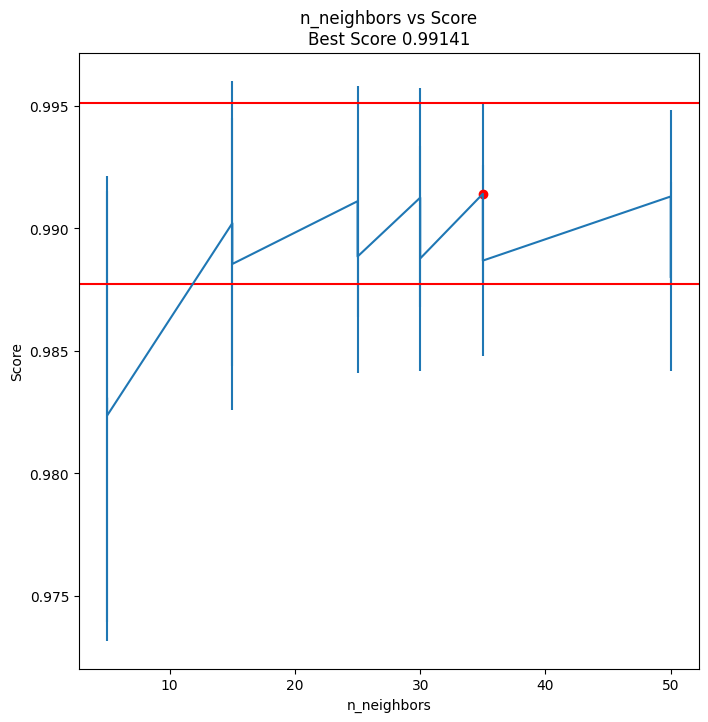

In [235]:
# Report best Number of Neighbors
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)
#print('Best k parameter : '+ str(grid_knn_acc.best_estimator_.n_neighbors))
#print('Best weights parameter : '+ str(grid_knn_acc.best_estimator_.weights))

In [236]:
print('best parameters:', grid_knn_acc.best_params_)
print('best score:', grid_knn_acc.best_score_)

best parameters: {'n_neighbors': 35, 'weights': 'distance'}
best score: 0.9914090653316849


In [237]:
# Assessing Results:
grid_knn_acc.predict(X_test)[0:5]


array([0, 0, 0, 0, 0])

In [238]:
grid_knn_acc.predict_proba(X_test)[0:5]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.74037525, 0.25962475],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [239]:
#Calculating Performance Scores
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
#InSample (Train)
insample_y_predict = grid_knn_acc.predict(X_train)

print('the accuracy score for best estimator: ', accuracy_score(y_train,insample_y_predict))
print('the precision score for best estimator: ', precision_score(y_train,insample_y_predict))
print('the recall score for best estimator: ', recall_score(y_train,insample_y_predict))
print('the f1_score score for best estimator: ', f1_score(y_train,insample_y_predict))

the accuracy score for best estimator:  1.0
the precision score for best estimator:  1.0
the f1_score score for best estimator:  1.0
the accuracy score for best estimator:  1.0


In [242]:
#Out of Sample (Test)
y_predict = grid_knn_acc.predict(X_test)

print('the accuracy score for best estimator: ', accuracy_score(y_test,y_predict))
print('the precision score for best estimator: ', precision_score(y_test,y_predict))
print('the recall score for best estimator: ', recall_score(y_test,y_predict))
print('the f1_score score for best estimator: ', f1_score(y_test,y_predict))

the accuracy score for best estimator:  0.9843468283887887
the precision score for best estimator:  0.9273356401384083
the f1_score score for best estimator:  0.7372764786795049
the recall score for best estimator:  0.6118721461187214


In [28]:
# Suggestions:

# Choose a manageable but meaningful set of hyperparameters to search on

N.B. Use a scoring metric that makes sense in a context of class imbalance. For a list of scoring rules, check 
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter. Some scoring rules that you might want to try: balanced_accuracy, f1, roc_auc.

Confusion matrix


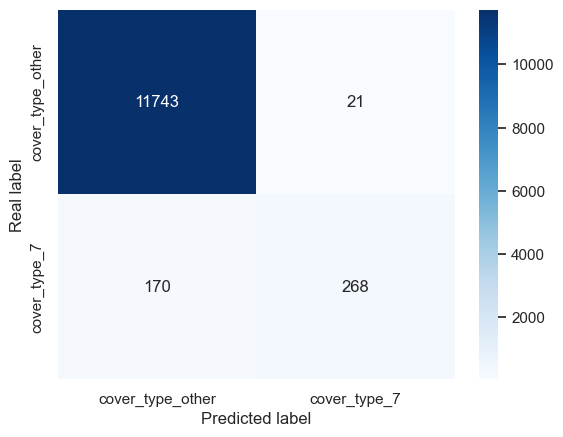

y actual : 
is_cover_7
0    11764
1      438
Name: count, dtype: int64
y predicted : 
0    11913
1      289
Name: count, dtype: int64


In [243]:
#Confusion matrix
print("Confusion matrix")
cm=confusion_matrix(y_test,y_predict)
plot_confusion_matrix(cm, ['cover_type_other','cover_type_7'])
#Distribution of y test
print('y actual : \n' +  str(y_test.value_counts()))
#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(y_predict).value_counts()))

#### c): Test the model on the test split

In [32]:
# Suggestions:

# Check the Confusion Matrix
# Check various performance metrics and try to make sense of them

**Some scoring metrics:**

+ **Accuracy score**: number of correctly classified observations over the total number of observations, $\frac{TP+TN}{\textit{Total obs.}}$.

+ **Precision score**: ratio of correctly predicted positive observations to the total predicted positive observations, $\frac{TP}{\text{TP + FP}}$. To improve precision, we want to lower the number of observations we predicted to be positive when they were not (False Positive). 

+ **Recall score**: ratio of correctly predicted positive observations to the total true positive observations, $\frac{TP}{\text{TP + FN}}$. To improve recall, we want to lower the number of observations we predicted to be negative when they were not (False Negative). It is also called *sensitivity* or True Positive Rate (TPR).

+ **F1 score**:  harmonic mean of the precision and recall, $\frac{2*Precision*Recall}{\textit{Precision + Recall}}$. An F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.

+ **Roc-auc score**: The Receiver Operator Characteristic (ROC) curve is a probability curve that plots the Recall (or TPR) against the False Positive Rate (FPR )** at various threshold values. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

    \** FPR = 1 - False Negative Rate (FNR or Specificity). The FNR tells us what proportion of the positive class got incorrectly classified by the classifier, $\frac{FN}{\text{TP + FN}}$ 
    
 

### Step 5: Try to improve your model using methods to tackle class imbalance.

In [ ]:
# Suggestions: 
# Re-do steps 1) to 3) with over-sampling and see whether you obtain an improvement

N.B. For tools to implement different over-sampling techniques check: https://imbalanced-learn.org/stable/over_sampling.html. Techniques you might want to check: random over-sampling, SMOTE, ADASYN. 